# Data Science Capstone Project 
### John Heinitz
### Febuary 7, 2021

## 1. Introduction

### 1.1 Background 

#### Owning and operating a small business has been a dream of mine since I was a kid. The data analysis provided below will hopefully allow me to turn that long-term dream into a REALITY. The small business I will be trying to start is a restaurant. The two main aspects to a successful restaurant are location and menu. Therefore, I will be focusing on how to pick the location and what types of food and drink I would offer.

### 1.2 Problem

#### Let's take a closer look into how I might be able to solve my current roadblocks, location and menu. Starting with location, I am hoping to start the business somewhere in Washington state that is established, while offering a high expected population growth rate. Finding an area with a high expected growth rate will be key to the long-term success of the restaurant. To achieve this, I will outline the top growth counties in Washington State to narrow my search. Once the top ten location areas have been determined, I will determine the optimal menu based on the competition surrounding the area and population demographics.

## 2. Data acquisition and cleaning

### 2.1 Data Sources

#### Population data - Used to narrow down ten possible locations. The data source will allow me to forecast population trends by county and can be found here:: https://ofm.wa.gov/washington-data-research/population-demographics/population-estimates/estimates-april-1-population-age-sex-race-and-hispanic-origin . 
#### Four square API data - Used to determine menu. The menu decision will rely on what the top counties currently offer and what it may be missing. I am hopeful to outline a cuisine that isn't saturated but still shows success in comparable counties. The data source can be found here: https://developer.foursquare.com/ . (*Note -- The data will be accessed using an API call outlined during the exploratory data analysis section.)

## 3. Methodology

### 3.1 Import necessary packages for project 

In [51]:
import pandas as pd 
import numpy as np
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet                  # Will be used to forecast population
from statsmodels.tsa.arima_model import ARIMA  # Will be used to forecast population - model comparison
import pmdarima as pm                          # Will be used to forecast population - model comparison
import warnings
import folium
import requests
print('Finished importing necessary packages')

Finished importing necessary packages


### 3.2 Population Data via OFM

### Data is pulled from the Office of Financial Management

#### The below data and graph highlight the remaining potential counties I would set up shop in. I have limited the areas based on 'established' areas. Once again, established is defined as the top 10 counties in WA state based on total population. This is the reason for sorting the values and calling top ten using the head function. The data will also be utilized to determine growth rates, which will solve my second problem stated above. 

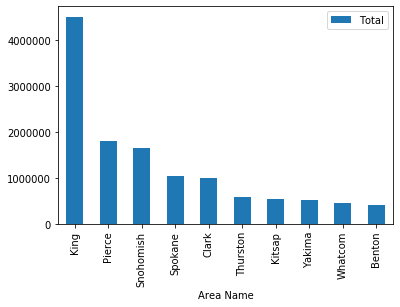

    Area Name       Total
16       King  4521599.98
26     Pierce  1801399.99
30  Snohomish  1660999.99
31    Spokane  1045200.00
5       Clark   998400.01
33   Thurston   581999.98
17     Kitsap   544400.01
38     Yakima   516399.99
36    Whatcom   456000.00
2      Benton   411400.00


In [85]:
# Read in data 
set1 = pd.read_excel('https://www.ofm.wa.gov/sites/default/files/public/dataresearch/pop/asr/sade/ofm_pop_sade_county_2000_to_2010.xlsx', sheet_name='Total')
set2 = pd.read_excel('https://www.ofm.wa.gov/sites/default/files/public/dataresearch/pop/asr/sade/ofm_pop_sade_county_2010_to_2020.xlsx', sheet_name='Total')

# Clean up files 
set1 = set1.loc[~set1.isin(['.']).any(axis=1)].reset_index()
set2 = set2.loc[~set2.isin(['.']).any(axis=1)].reset_index()
# Drop year 2010 from set2 since it lives in set1 already - then concat frames to one source
set2 = set2.loc[~set2.Year.isin([2010]),:]
main = pd.concat([set1,set2])
# Drop Washington aggregate 
main = main.loc[~main['Area Name'].isin(['Washington']),:]
# Select top 10 established counties - based on 2020 total population
county_pop = main.loc[main.Year == 2020,['Area Name','Total']].groupby(['Area Name']).sum().reset_index()
# Limit to top 10 
est = county_pop.sort_values('Total',ascending = False).head(10)
est.plot(kind='bar', x='Area Name',y='Total') ; plt.show()
print(est)

In [37]:
# Subset main (population data) down to only established counties for further evaluation
main = main.loc[main['Area Name'].isin(est['Area Name']),:]
# Create new column based on County and Age ; column will allow for arima and fbprophet model call
main.loc[:,'County_Age'] = main['Area Name'] + '_' + main['Age Group']

### 3.3 Forecast county population by age group using Fbprophet and ARIMA models

#### Now that I have ten possible locations, I will now limit it to three for further review based on expected population growth. The rationale for down selecting on this criteria is to determine the long term success of this endeavor. The worst outcome is to set up shop in a location that doesn't offer room for growth. I am hopeful the number of customers can grow at or above the rate of the population. I ended up using two time series models to evaluate growth. I have included links to both models below.

#### FB model documentation here: https://pypi.org/project/fbprophet/

#### Arima model documentation here: https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html

#### A few issues arose while setting up the FB prophet model. The main issue stemmed from using yearly data compared to what the model prefers, which is daily. Forcing the model to use yearly data disabled daily and weekly seasonality patterns. The forecasted ended up being highly variable and even include many negative forecasts. Rather than continuing to tune the model parameters, I have decided to try an auto-ARIMA model below. I will leave this fb model as a proof of concept for future endeavors or others that might be interested in setting up the FB model (*Note Pystan needs to be installed prior).

In [64]:
# Forecast using Prophet model 
# Clean up main to interested columns 
# Subsetted one group to test model: Benton_0-4
main_cleaned = main.loc[:,['Year','County_Age','Total']].rename(columns={'Total':'Population'})
# For testing model and tuning parameters
main_cleaned = main_cleaned.loc[main_cleaned['County_Age'] == 'Benton_0-4']
# Cast Year to datetime to use in Prophet call
main_cleaned.Year = main_cleaned.Year.astype(str) + '/' + '01' + '/' + '01'
main_cleaned.Year = pd.to_datetime(main_cleaned.Year, format='%Y/%d/%m')
main_cleaned.Population = main_cleaned.Population.astype(np.float64)
# parameters to pass during model call below 
forecasts_dict = {}
cut_off_date = '2017-01-01'
years_to_forecast = 15
dfLst = []

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 3.
C:\Users\JH\anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


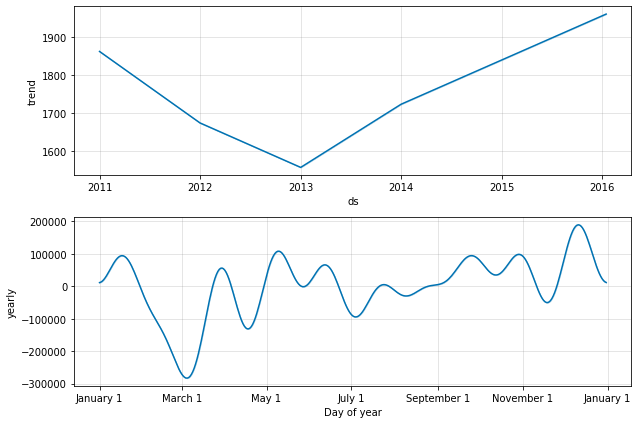

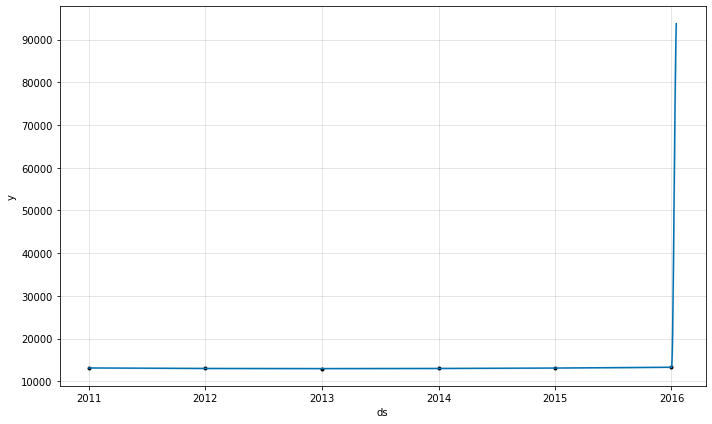

In [65]:
for County_Age in main_cleaned.County_Age.unique():
    # Create train and val (test) dataframes
    train_df = main_cleaned.loc[(main_cleaned.Year <  cut_off_date) & (main_cleaned.County_Age == County_Age),\
        ['Year','Population']].groupby('Year').sum().reset_index()
    val_df   = main_cleaned.loc[(main_cleaned.Year >=  cut_off_date)& (main_cleaned.County_Age == County_Age),\
        ['Year','Population']].groupby('Year').sum().reset_index()
    # Prepare data for prophet call - rename columns to flow through Prophet (Prophet requires "ds" and "y" variables) 
    train_df = train_df.rename(columns={'Year':'ds','Population':'y'})
    # Determine inputs for model 
    # prophet_basic = Prophet(yearly_seasonality=True,weekly_seasonality=True, daily_seasonality=True)
    prophet_basic = Prophet()
    # Fit model to train dataframe 
    prophet_basic.fit(train_df)
    # Make dataframe for predictions
    future = prophet_basic.make_future_dataframe(periods=years_to_forecast)
    # Forecast
    forecast = prophet_basic.predict(future)
    # Plot forecast
    prophet_basic.plot_components(forecast)
    plt.show()
    fig = prophet_basic.plot(forecast)
    plt.show()
    # Save off Forecasts
    predictions = forecast.loc[:,['ds','yhat']]
    predictions.loc[:,'County_Age'] = County_Age
    dfLst.append(predictions)

appended_data = pd.concat(dfLst)

#### Show forecasted values

In [67]:
appended_data.head(25)

### 3.4 Forecast county population by age group using ARIMA model 

In [38]:
main_cleaned = main.loc[:,['Year','County_Age','Total']].rename(columns={'Total':'Population'})
main_cleaned.head()

,Year,County_Age,Population
57,2000,Benton_0-4,10779.01
58,2000,Benton_5-9,11682
59,2000,Benton_10-14,12313
60,2000,Benton_15-19,11683
61,2000,Benton_20-24,8107


In [39]:
main_cleaned_pivot = pd.pivot_table(main_cleaned, values='Population', index='Year', columns='County_Age', aggfunc='sum').reset_index()
main_cleaned_pivot.loc[:,'Year'] = main_cleaned_pivot.loc[:,'Year'].astype(int)
main_cleaned_pivot.set_index('Year',inplace=True)

# For model testing 
# main_cleaned_pivot = main_cleaned_pivot.loc[:,['Benton_0-4','Benton_10-14']]

In [40]:
nuDates = [str(x) for x in range(2021,2031)]
cols = main_cleaned_pivot.columns
forecast_df = pd.DataFrame(columns=cols, index=np.append(main_cleaned_pivot.index.values,np.array(nuDates)))
forecast_df.head(5)

County_Age,Benton_0-4,Benton_10-14,Benton_15-19,Benton_20-24,Benton_25-29,Benton_30-34,Benton_35-39,Benton_40-44,Benton_45-49,Benton_5-9,...,Yakima_5-9,Yakima_50-54,Yakima_55-59,Yakima_60-64,Yakima_65-69,Yakima_70-74,Yakima_75-79,Yakima_80-84,Yakima_85+,Yakima_Total
2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# of forecasts
for col in cols:
    print(col)

Benton_0-4
Benton_10-14
Benton_15-19
Benton_20-24
Benton_25-29
Benton_30-34
Benton_35-39
Benton_40-44
Benton_45-49
Benton_5-9
Benton_50-54
Benton_55-59
Benton_60-64
Benton_65-69
Benton_70-74
Benton_75-79
Benton_80-84
Benton_85+
Benton_Total
Clark_0-4
Clark_10-14
Clark_15-19
Clark_20-24
Clark_25-29
Clark_30-34
Clark_35-39
Clark_40-44
Clark_45-49
Clark_5-9
Clark_50-54
Clark_55-59
Clark_60-64
Clark_65-69
Clark_70-74
Clark_75-79
Clark_80-84
Clark_85+
Clark_Total
King_0-4
King_10-14
King_15-19
King_20-24
King_25-29
King_30-34
King_35-39
King_40-44
King_45-49
King_5-9
King_50-54
King_55-59
King_60-64
King_65-69
King_70-74
King_75-79
King_80-84
King_85+
King_Total
Kitsap_0-4
Kitsap_10-14
Kitsap_15-19
Kitsap_20-24
Kitsap_25-29
Kitsap_30-34
Kitsap_35-39
Kitsap_40-44
Kitsap_45-49
Kitsap_5-9
Kitsap_50-54
Kitsap_55-59
Kitsap_60-64
Kitsap_65-69
Kitsap_70-74
Kitsap_75-79
Kitsap_80-84
Kitsap_85+
Kitsap_Total
Pierce_0-4
Pierce_10-14
Pierce_15-19
Pierce_20-24
Pierce_25-29
Pierce_30-34
Pierce_35-39
Pier

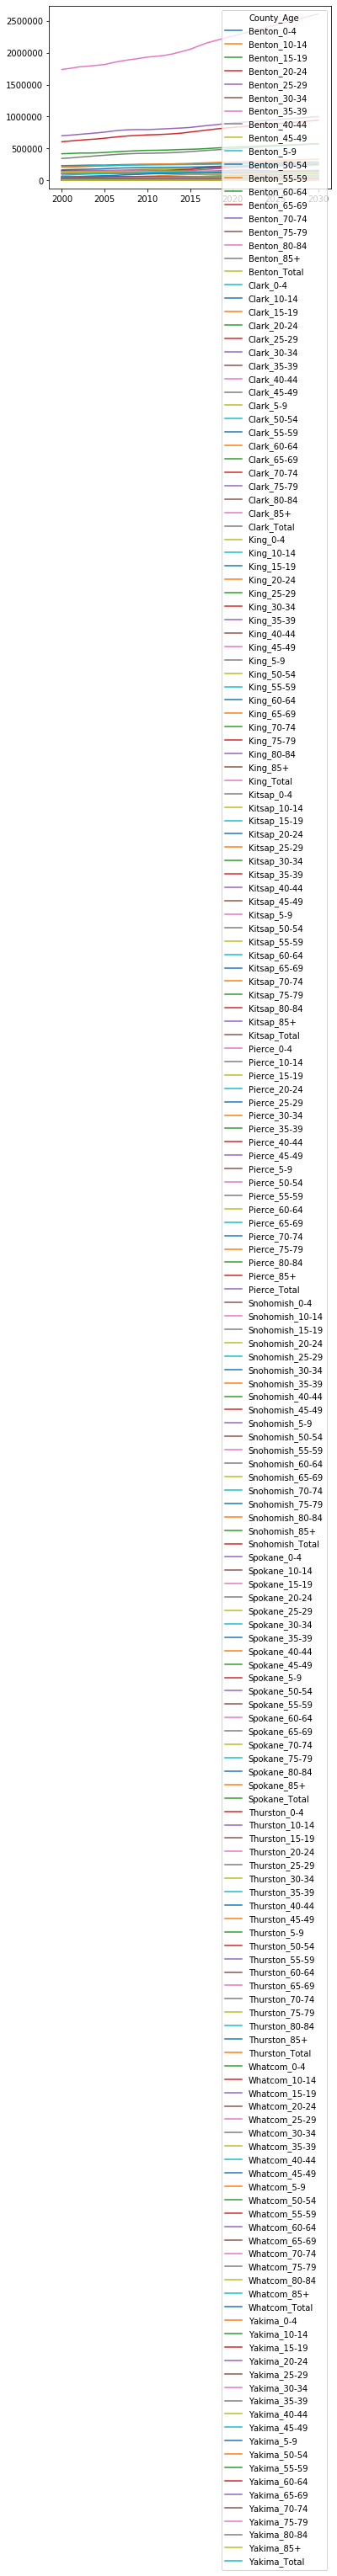

In [42]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for col in cols:
        model = pm.auto_arima(main_cleaned_pivot[col])
        predictions = model.predict(len(nuDates))
        forecast_df.loc[:,col] = np.append(main_cleaned_pivot[col].values,predictions)

forecast_df.plot()
plt.show()

#### The Restaurant will target ages between 20 to 39, I could have limited the data frame earlier but was hoping to demonstrate more forecasts through the auto Arima model. Also notice the growth rate is calculated by county after down selecting the interested age ranges. Remember that I chose the top 10 counties based on establishment (total population) and will now narrow it down to three counties based on expected growth rate in these age groups.

In [43]:
# Format forecast dataframe and calculate 10 year growth rate
main_forecast = forecast_df.transpose()
main_forecast = main_forecast.reset_index()
main_forecast.County_Age = main_forecast.County_Age.str.strip()
main_forecast[['County','Age']] = main_forecast['County_Age'].str.split('_',expand=True)
main_forecast = main_forecast.reset_index()
main_forecast.head()

# Down select frame to only necessary age ranges to determine growth in those sections
of_interest = main_forecast.loc[main_forecast['Age'].isin(['20-24','25-29','30-34','35-39'])]
of_interest = of_interest.iloc[:,2:35]
of_interest = of_interest.groupby(by=['County']).sum()
# of_interest.head()

# Calculate expected 10 year growth rate (2030 from 2020) - and limit to three counties for final review
of_interest.loc[:,'Growth_ten'] = of_interest['2030'].div(of_interest['2021'])
of_interest = of_interest.sort_values(by='Growth_ten', ascending=False)[0:3]

### 4. Foursquare data to make decision on location

#### Set your own credentials below to follow along

In [44]:
# @hidden_cell
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: SSR1ZMDGOWTBN5PTWLTOX40F0SVJPR1PUXCP0KDE2VRMHVRF
CLIENT_SECRET:WFJUUWFGOFZZ04OREJIJJYPANAQUYE3NJBTKKJBUK0JGGY0V


### 4.1 set latitude and longitude coordinates to last three counties

In [45]:
dt = [['King',47.59717,-122.30986],['Benton',46.26322,-119.52718],['Thurston',47.03865,-122.91940]]
foo = pd.DataFrame(data=dt, columns=['County','Latitude','Longitude'])
of_interest = of_interest.reset_index()

In [46]:
final_three = of_interest.merge(foo, how='left',on=['County'])
final_three.head()

,County,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2024,2025,2026,2027,2028,2029,2030,Growth_ten,Latitude,Longitude
0,King,566584.83,565023.04,566532.00,564312.0,564061.00,565244.08,575724.0,583943.0,589079.0,...,844218.412000,861411.882500,878605.353000,895798.823500,912992.294000,930185.764500,947379.235000,1.195223,47.59717,-122.30986
1,Benton,36995.00,37433.92,38036.85,38783.0,39657.00,40496.00,41516.0,42437.0,43176.0,...,52739.019478,53291.859468,53855.247720,54417.635990,54972.562128,55519.787069,56062.360450,1.096893,46.26322,-119.52718
2,Thurston,56734.96,56948.00,57615.00,58358.0,59371.95,60804.00,62402.0,64025.0,65506.0,...,74280.266796,74832.160975,75334.370193,75789.976519,76192.990376,76551.556850,76898.999782,1.067426,47.03865,-122.91940


### 4.2 Call Folium map to display counties and get familiar to map visualization

In [126]:
# create map of Wa using latitude and longitude values
map_wa = folium.Map(location=[final_three.Latitude[0], final_three.Longitude[0]], zoom_start=7.1)

# add markers to map
for lat, lng, label in zip(final_three['Latitude'], final_three['Longitude'], final_three['County']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_wa)  
    
map_wa

### 4.3 Find venues in a 1,000 meter radius from lat long 

In [69]:
LIMIT = 10000 # limit of number of venues returned by Foursquare API
radius = 10000 # define radius

#### Function to return venue categories

In [75]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['County', 
                  'County Latitude', 
                  'County Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [76]:
venues = getNearbyVenues(names=final_three['County'],
                                   latitudes=final_three['Latitude'],
                                   longitudes=final_three['Longitude']
                                  )

King
Benton
Thurston


In [78]:
venues

,County,County Latitude,County Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,King,47.59717,-122.30986,Seattle Bouldering Project,47.593505,-122.310925,Climbing Gym
1,King,47.59717,-122.30986,Pho Bac Sup Shop,47.599443,-122.315298,Vietnamese Restaurant
2,King,47.59717,-122.30986,Wood Shop BBQ,47.599141,-122.299249,BBQ Joint
3,King,47.59717,-122.30986,Seattle Fish Guys,47.598860,-122.302452,Seafood Restaurant
4,King,47.59717,-122.30986,Saigon Deli,47.599084,-122.315370,Vietnamese Restaurant
...,...,...,...,...,...,...,...
204,Thurston,47.03865,-122.91940,Kiperts Korner Feed Store,46.963887,-122.883647,Pet Store
205,Thurston,47.03865,-122.91940,Thrive Fitness,46.999181,-122.825293,Gym
206,Thurston,47.03865,-122.91940,Meconi's Italian Subs,46.982963,-122.904457,Sandwich Place
207,Thurston,47.03865,-122.91940,Jasmine Thai Cuisine,47.042985,-122.828749,Thai Restaurant


### 4.4  Venue counts per county

In [106]:
tmp = venues.loc[:,['County','Venue Category']].value_counts().reset_index()
tmp.rename(columns={0:'ValueCounts','Venue Category': 'VenueCategory'},inplace=True)
tmp.head()

,County,VenueCategory,ValueCounts
0,Thurston,Coffee Shop,12
1,King,Coffee Shop,8
2,Thurston,Park,7
3,King,Vietnamese Restaurant,5
4,Thurston,Sandwich Place,5


### 4.5 Determine what venues might be missing within each county

In [124]:
final = tmp.pivot_table(values='ValueCounts', columns='County', index='VenueCategory', aggfunc='sum')
final = final.fillna(0).reset_index()
final.head()

County,VenueCategory,Benton,King,Thurston
0,American Restaurant,0.0,0.0,1.0
1,Art Museum,0.0,1.0,0.0
2,BBQ Joint,0.0,1.0,0.0
3,Bakery,0.0,5.0,1.0
4,Bar,0.0,1.0,1.0


In [125]:
# limit final frame to venues of Restaurant (possible issues dropping venues such as "BBQ Place")
final = final.loc[final.VenueCategory.str.contains('Restaurant'),:]
final.sort_values(["Benton", "King","Thurston"], ascending = (False, False, False))

County,VenueCategory,Benton,King,Thurston
85,Vietnamese Restaurant,0.0,5.0,0.0
32,French Restaurant,0.0,3.0,0.0
75,Seafood Restaurant,0.0,2.0,2.0
49,Japanese Restaurant,0.0,2.0,0.0
48,Italian Restaurant,0.0,1.0,3.0
72,Restaurant,0.0,1.0,2.0
79,Sushi Restaurant,0.0,1.0,2.0
25,Ethiopian Restaurant,0.0,1.0,0.0
56,Malay Restaurant,0.0,1.0,0.0
59,Mediterranean Restaurant,0.0,1.0,0.0


## 5. Conclusion

#### The restaurant that I will be opening is an Italian restaurant in King county. To be honest, the rationale of this decision is mainly due to the established area King county has to offer and the expected growth rate. Unfortunately, using the four-square data and outlining restaurants in other counties did not offer additional information to base my decision. I will note that Thurston county has a higher presence of Italian restaurants and my thought is King county appears to lack this offering in the area.  I understand that the quantities are very minimal and offer limited guidance.  Future steps would include focusing in on the four-square data and brainstorming how I could use the information to drive a better decision. I guess that is the beauty of data science, the ability to keep outlining future opportunities and keep improving.